In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base= automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


In [33]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [36]:
#Use Inspector to explore the database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [39]:
#find columns in measurement file
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], columns["type"])

id FLOAT
station FLOAT
date FLOAT
prcp FLOAT
tobs FLOAT


In [40]:
#find columns in station file
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], columns["type"])

id FLOAT
station FLOAT
name FLOAT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Find the most recent date in the data set.

latest_date = engine.execute('select max(date) from measurement').fetchone()
print(latest_date) 


('2017-08-23',)


In [49]:
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [52]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date ).\
order_by(Measurement.date).all()
#print(precip_data)

In [54]:
# Save the query results as a Pandas DataFrame 
precip_df = pd.DataFrame(precip_data)
precip_data_df = precip_df.rename(columns={"prcp":"Precipitation"})
precip_data_df.tail()

,date,Precipitation
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08
2229,2017-08-23,0.45


In [55]:
#set the index to the date column
precip_data_df.set_index('date').head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


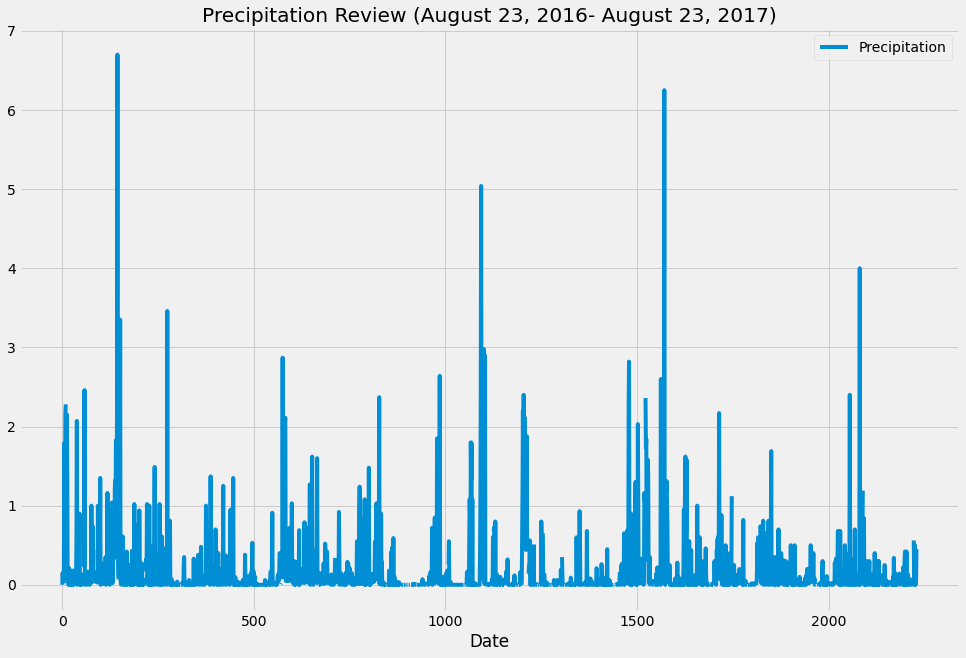

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_data_df.plot(figsize=(15,10))
ax.set_title(f"Precipitation Review (August 23, 2016- August 23, 2017)")
ax.set_xlabel('Date')
plt.show()


In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number stations in the dataset
ttl_stations = session.query(Station.id).count()
print(ttl_stations)


9


In [69]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

active_stations = session.query(Measurement.station, 
                   func.count(Measurement.station))\
 .group_by(Measurement.station)\
 .order_by(func.count(Measurement.station).desc()).limit(6).all()
for station in active_stations:
    #print(active_stations)
# List the stations and the counts in descending order.
    print(f"One of the most active stations is {station[0]}, and the total count is {station[1]}.")

One of the most active stations is USC00519281, and the total count is 2772.
One of the most active stations is USC00519397, and the total count is 2724.
One of the most active stations is USC00513117, and the total count is 2709.
One of the most active stations is USC00519523, and the total count is 2669.
One of the most active stations is USC00516128, and the total count is 2612.
One of the most active stations is USC00514830, and the total count is 2202.


In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station,
                      func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(1).all()
#print(most_active_station)
most_active = session.query(Station.id,
              Station.name,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == most_active_station[0][0])
avg_temp = "{0:.2f}".format(most_active[0][4])
print(f"Most active station id: {most_active[0][0]},\n\
Name: {most_active_station[0][0]},\n\
Location: {most_active[0][1]} \n\n\
Minimum temperature recorded: {most_active[0][2]}\nMaximum temperature recorded: {most_active[0][3]}\n\
Average temperature recorded: {avg_temp}")


Most active station id: 7,
Name: USC00519281,
Location: WAIHEE 837.5, HI US 

Minimum temperature recorded: 54.0
Maximum temperature recorded: 85.0
Average temperature recorded: 71.66


In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
temp_data = session.query(Measurement.tobs).\
             filter(Measurement.station==most_active_station[0][0]).\
             filter(Measurement.date >= query_date).\
             order_by(Measurement.date.desc()).all()
temp_data_df = pd.DataFrame(temp_data)
temp_data_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


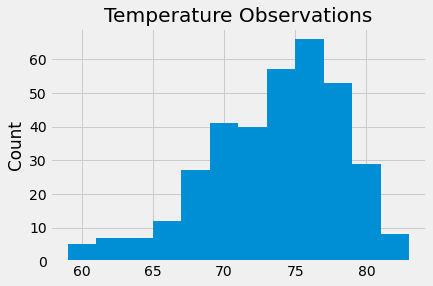

In [76]:
#and plot the results as a histogram
plt.hist(temp_data_df['tobs'], bins=12)
plt.ylabel("Count")
plt.title("Temperature Observations")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()